In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
learning_rate = 1e-3
num_epochs = 5000
alpha = 0.1  # Thermal diffusivity

In [2]:
# Define the PINN architecture
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Output u(x, t)
        )

    def forward(self, x, t):
        inputs = torch.cat((x, t), dim=1)  # Concatenate x and t
        return self.net(inputs)

# Instantiate model
model = PINN().to(device)

In [3]:
# Loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Generate training points
N_x = 10000  # Samples in x
N_T = 10000  # samples in time
N_bc = 100   # Boundary condition points

# Random collocation points for PDE loss
x_f = torch.rand(N_x, 1, device=device)  # x ∈ (0,1)
t_f = torch.rand(N_T, 1, device=device)  # t ∈ (0,1)

# Boundary points
x_bc_0 = torch.zeros(N_bc, 1, device=device)  # x = 0
x_bc_1 = torch.ones(N_bc, 1, device=device)   # x = 1
t_bc = torch.rand(N_bc, 1, device=device)     # Random t values for BC

# Initial condition points
x_ic = torch.rand(N_bc, 1, device=device)  # x ∈ (0,1)
t_ic = torch.zeros(N_bc, 1, device=device) # t = 0
u_ic = torch.sin(torch.pi * x_ic).to(device)  # u(x,0) = sin(pi x)

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Compute physics loss (heat equation residual)
    x_f.requires_grad = True
    t_f.requires_grad = True
    u_pred = model(x_f, t_f)

    # Compute derivatives using autograd
    u_t = torch.autograd.grad(u_pred, t_f, torch.ones_like(u_pred), create_graph=True)[0]
    u_x = torch.autograd.grad(u_pred, x_f, torch.ones_like(u_pred), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_f, torch.ones_like(u_x), create_graph=True)[0]

    physics_residual = u_t - alpha * u_xx
    physics_loss = torch.mean(physics_residual**2)

    # Compute boundary loss
    u_bc_0 = model(x_bc_0, t_bc)
    u_bc_1 = model(x_bc_1, t_bc)
    boundary_loss = torch.mean(u_bc_0**2) + torch.mean(u_bc_1**2)

    # Compute initial condition loss
    u_ic_pred = model(x_ic, t_ic)
    initial_loss = torch.mean((u_ic_pred - u_ic) ** 2)

    # Total loss
    loss = physics_loss + boundary_loss + initial_loss
    loss.backward()
    optimizer.step()

    # Print progress
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}')

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss: 0.416196
Epoch 500, Loss: 0.000323
Epoch 1000, Loss: 0.000068
Epoch 1500, Loss: 0.000043
Epoch 2000, Loss: 0.001961
Epoch 2500, Loss: 0.000021
Epoch 3000, Loss: 0.000015
Epoch 3500, Loss: 0.000011
Epoch 4000, Loss: 0.000009
Epoch 4500, Loss: 0.000009


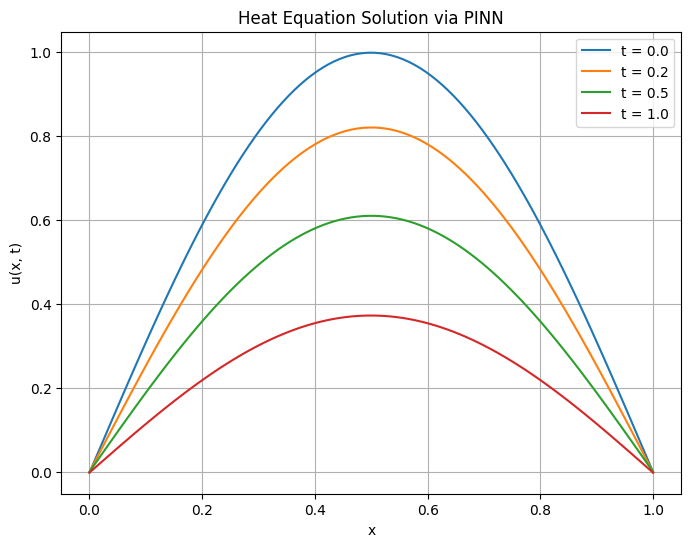

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values
x_values = np.linspace(0, 1, 100)  # 100 points in space

# Times at which we want to visualize the solution
time_steps = [0.0, 0.2, 0.5, 1.0]

# Create plots at different time steps
plt.figure(figsize=(8, 6))

for t in time_steps:
    x_tensor = torch.tensor(x_values, dtype=torch.float32, device=device).unsqueeze(1)
    t_tensor = torch.tensor([t] * len(x_values), dtype=torch.float32, device=device).unsqueeze(1)

    with torch.no_grad():
        u_pred = model(x_tensor, t_tensor).cpu().numpy().flatten()

    plt.plot(x_values, u_pred, label=f"t = {t}")

plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.title("Heat Equation Solution via PINN")
plt.legend()
plt.grid(True)
plt.show()
